# STEP 0. 환경 구성

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

# STEP 1. 데이터셋 구성

- 1) tf.keras에서 cifar10 데이터셋 가져옴
- 2) train_x 이미지 -1, 1 정규화
- 3) 미니배치 데이터셋 구성 (tf.data.Dataset 모듈의 from_tensor_slices() 사용

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data() #카테고리 나타내는 라벨 필요없으니 _(언더스코어) 사용

train_x.shape

(50000, 32, 32, 3)

이미지 픽셀 확인

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


이미지 -1,1로 정규화

In [ ]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
#train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
#train_x.shape

이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

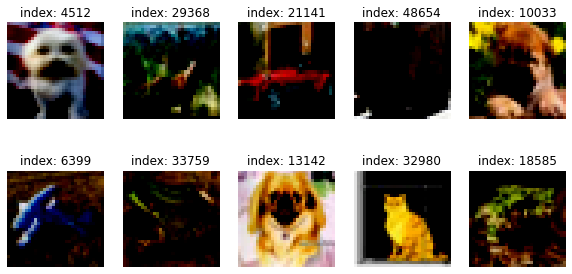

In [ ]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

미니배치

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# STEP2. 생성자 모델 구현

- 1) (32, 32, 3) shape 이미지 생성자 모델 구현 함수
- 2) 랜덤 노이즈 입력으로하여 구현한 생성자로 랜덤 이미지 생성 (noise = tf.random.normal([1, 100])
- 3) 생성된 이미지가 생성자 출력 규격에 맞는지 확인

In [ ]:
def make_generator_model():

    # 0
    model = tf.keras.Sequential() #Keras Sequential API 활용

    # 1: Dense layer
    # 마지막에 32, 32 만들기 위해 8을 입력
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 2: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # 3: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 4: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 5: Conv2DTranspose layer
    # 32, 32, 3 만들기 위해 3입력
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_58 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_58 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_59 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 8, 8, 128)       

랜덤 노이즈 벡터 생성

In [ ]:
noise = tf.random.normal([1, 100]) #tf.random.normal() 활용

batch_size=1, (32, 32, 3) 사이즈 이미지

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

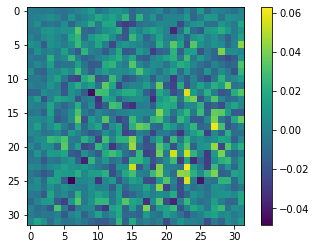

In [ ]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

# STEP3. 판별자 모델 구현

- 1) (32, 32, 3) 이미지 입력, 1차원 판별결과 출력하는 판별자 모델 구현 함수
- 2) STEP2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값 확인

In [ ]:
def make_discriminator_model():

    # 0
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 2: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 3: Flatten Layer
    model.add(layers.Flatten())

    # 4: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0049991]], dtype=float32)>

# STEP4. 손실함수, 최적화 함수 구현

- 1) 생성자, 판별자 손실함수(loss) 구현
- 2) 판별자 출력값으로 이미지 판별 정확도 계산하는 함수 (real/fake)
- 3) 최적화 optimizer 정의

loss를 계산하기 위한 교차 엔트로피 생성

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

생성자 손실함수 (generator loss)

1에 가까울수록 값이 작아짐

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

판별자 손실함수 (dicriminator_loss)

real output은 1, fake output은 0에 가까워져야 함

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

판별 정확도 (discriminator accuracy)

- GAN 학습에서 accuracy 계산해 보는 것은 중요
- real accuracy, fake accuracy 모두 초반에 1.0 가까운 값에서 0.5에 가까워져야 함

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

최적화 함수 (optimizer)

In [ ]:
# 생성자 optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #1e-4=0.0001 (learning rate)
# 판별자 optimizer
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

생성자 생성 샘플 확인을 위한 노이즈 만들기

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# STEP5. 훈련과정 상세 기능 구현하기

- 1) train_step() 함수 구현 (1개 미니배치 훈련 과정 처리)
- 2) generate_and_save_images() 함수 구현 (16개 고정 seed 입력으로 받고 훈련 과정에서 생성한 이미지 시각화)
- 3) draw_train_history() 함수 구현 (훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy history 그래프 시각화)
- 4) checkpoint 모듈 설정 (training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장)

train_step()

In [ ]:
#@tf.function 데코레이터 사용 (session 열고 닫는 과정 내부적으로 처리해 줌)

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈 (생성자 가짜 이미지 생성 위함)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈 (가중치를 위한 gradient를 자동으로 미분)
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습 (가중치 갱신)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) loss, accuracy 값 리턴

generate_and_save_images()

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
   #try : 
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it)) #이미지 파일 저장

    plt.show()

draw_train_history()

In [ ]:
#매 epoch마다 시각화

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

checkpoint

In [ ]:
# 예외 상황 발생 시 대처하기 위해 모델의 optimizer, generator, discriminator 자동 저장

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP6. 학습 진행 & STEP7. GAN 훈련 과정 개선

- 1) 최소 50 epoch 학습
- 2) gif 파일로 학습 진행 과정 시각적으로 표현
- 3) 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 200

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

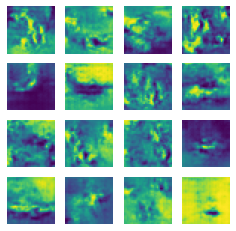

Time for training : 6049 sec


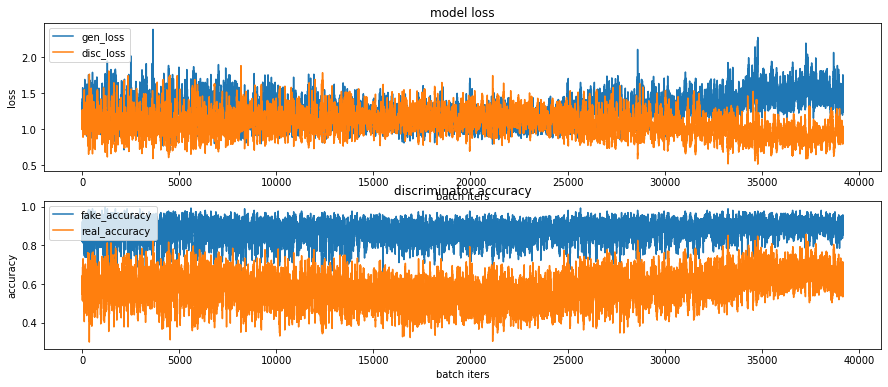

CPU times: user 1h 40min 43s, sys: 1min 38s, total: 1h 42min 22s
Wall time: 1h 40min 51s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

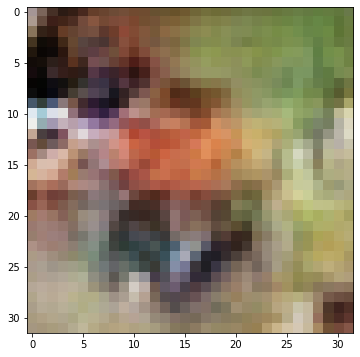

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show() 

In [ ]:
save_every = 5
EPOCHS = 100

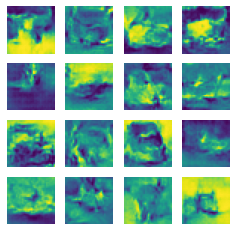

Time for training : 2885 sec


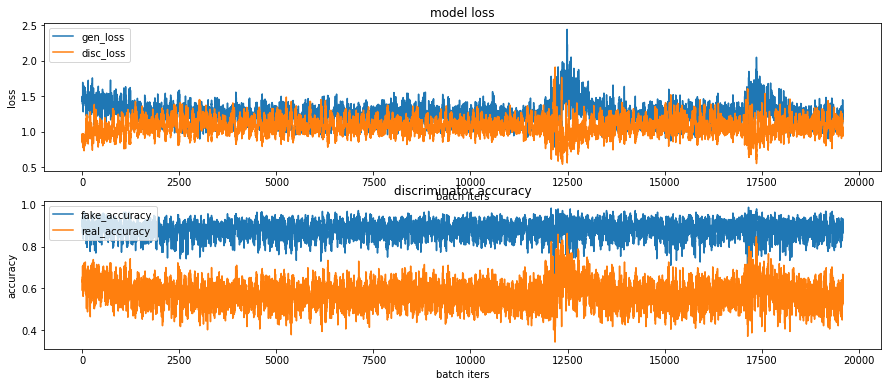

CPU times: user 48min 9s, sys: 51.8 s, total: 49min
Wall time: 48min 6s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

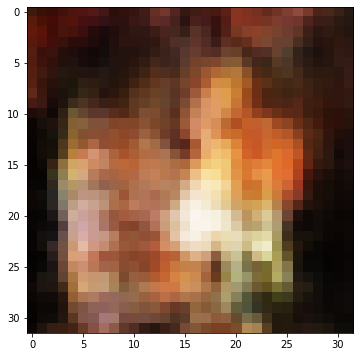

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  

In [ ]:
save_every = 5
EPOCHS = 100

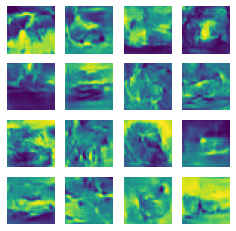

Time for training : 2877 sec


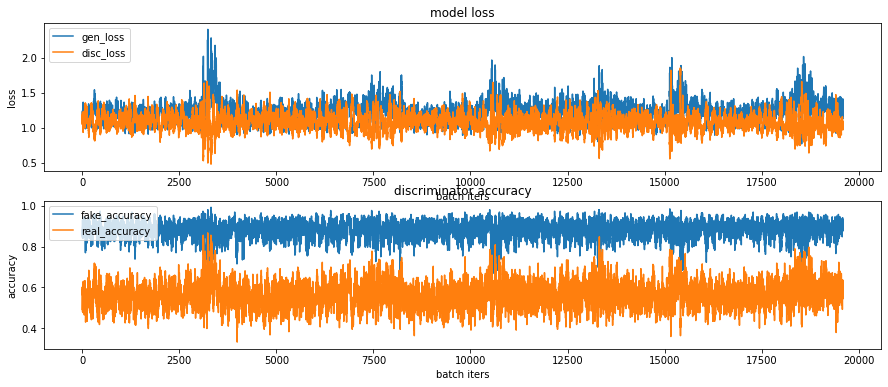

CPU times: user 48min 1s, sys: 51.2 s, total: 48min 52s
Wall time: 47min 58s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

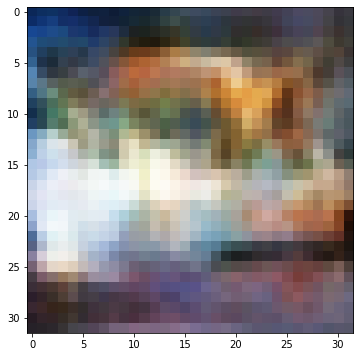

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show() 

In [ ]:
save_every = 5
EPOCHS = 100

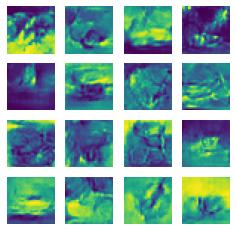

Time for training : 2885 sec


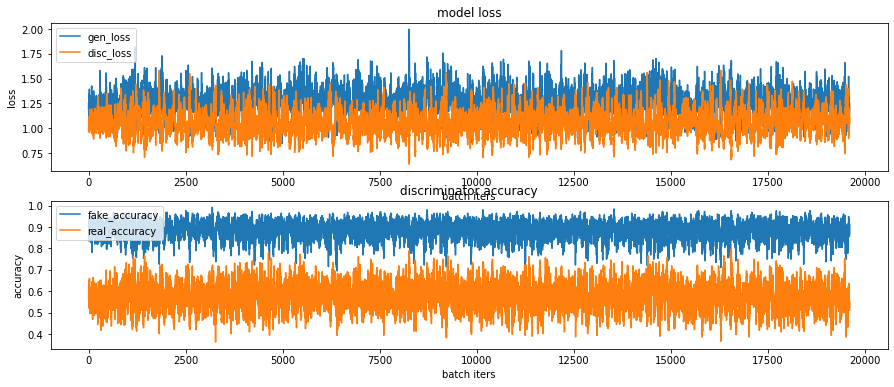

CPU times: user 48min 10s, sys: 51.5 s, total: 49min 1s
Wall time: 48min 6s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

learning rate 0.00001

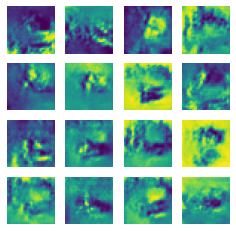

Time for training : 15266 sec


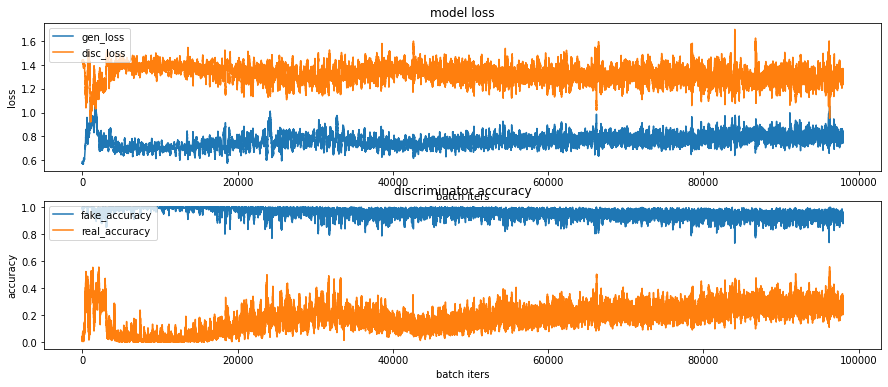

CPU times: user 4h 14min 46s, sys: 2min 17s, total: 4h 17min 3s
Wall time: 4h 14min 30s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 회고

개선 아이디어 적용 결과

##### [learning rate를 0.0001로 하고 epochs를 변경한 경우]
- epochs 200 : 격자 무늬가 보이며 사물의 형체를 알아볼 수 없다.
- epochs 300 : 형체가 나오기 시작한다.
- epochs 400 : 형체가 뚜렷해지기 시작한다.
- epochs 500 : 형체의 경계가 자연스러워지고 물체의 대상이 육안으로 유추되기 시작한다.

##### [accuracy 추이]
- epochs 200 : fake_accuracy 0.7-1.0(0.8점대), real_accuracy 0.3-0.8(0.6)
- epochs 300 : fake_accuracy 0.8-1.0(0.8점대), real_accuracy 0.3-0.8(0.6)
- epochs 400 : fake_accuracy 0.7-1.0(0.8점대), real_accuracy 0.3-0.8(0.5점대)
- epochs 500 : fake_accuracy 0.7-1.0(0.7근접), real_accuracy 0.3-0.8(0.5점대)
- learning rate 0.00001, epochs 500 : fake_accuracy가 learning rate 0.0001일 때보다 개선 안 됨.
- ==> learning rate는 0.0001보다 작게 하지 않고 다른 요인을 변경하는 것이 좋은 결과를 만들 것 같다.

==> 충분한 학습이 필요하다고 생각되어 epochs를 늘렸더니, 점점 사진 속 형체가 유추될 수 있을 정도로 시각적으로 개선되었다.

##### gif

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif'

In [ ]:
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif

-rw-r--r-- 1 root root 2685511 Sep  2 14:06 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif


learning rate 0.0001, epochs 500

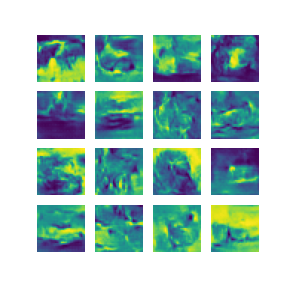

learning rate 0.00001, epochs 500

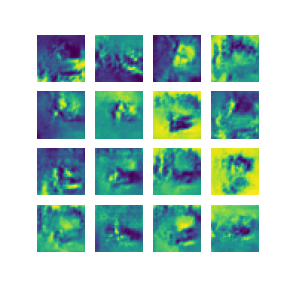

==> real_accuracy는 0.5점대에 근접하였지만, fake_accuracy는 0.7정도로 근접하였다. epoch를 더 늘려서 학습해 보는 실험이 필요하다.

느낀점 : 학습하는 데 많은 시간이 소요되어 여유를 가지고 접근해야 하는 분야라는 생각이 들었다.